
# **Trabajo Práctico 1 : Reservas de Hotel**
### *Checkpoint 3*
###Grupo 22: JARVIS
+ 107666	CELANO MINIG, NICOLÁS FRANCO
+ 108642	RANDO, JULIAN AGUSTIN
+ 106421	GOMEZ, ALEJO



Realizamos los importes necesarios

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


Bajamos los dataframes que usaremos.

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Realizamos el tratamiento de datos que consideramos necesarios.


In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

Con la siguiente funcion cambiaremos de algunas columnas por el valor de su media.

In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

Lo hacemos en coutry, agent y company ya que tienen muchas columnas y realizar otro tipo de tratado de datos, como por ejemplo dummies aumenta mucho la dimensionalidad.

In [ ]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

Separamos los datos y realizamos dummies de los datos restantes.

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

Completamos con las columnas necesarias.

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'random_state': [42]
}


rfc = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = rfc.fit(X = X_train, y = y_train) 

random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=1, cv=5, scoring='f1')

random_search.fit(X, y)

best_params = random_search.best_params_
best_model = RandomForestClassifier(**best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)


Mejores hiperparámetros encontrados: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 951, 'random_state': 42}
F1_score en el conjunto de prueba: 0.8552898256992298
Accuracy en el conjunto de prueba: 0.8548544478777037
Precision en el conjunto de prueba: 0.8484799742641145


Text(50.722222222222214, 0.5, 'True')

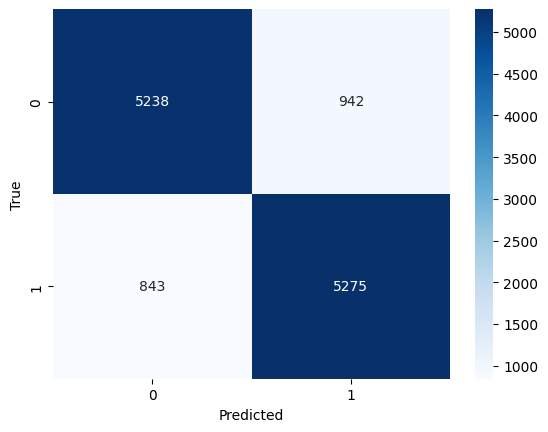

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
param_dist = {
    'n_estimators': randint(650, 850),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(7, 47),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 15),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'random_state': [42]
}


rfc = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=3, cv=10, scoring='f1')

random_search.fit(X, y)

best_params = random_search.best_params_
best_model = RandomForestClassifier(**best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)

Mejores hiperparámetros encontrados: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 41, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 740, 'random_state': 42}
F1_score en el conjunto de prueba: 0.875839144886919
Accuracy en el conjunto de prueba: 0.8760814414883237
Precision en el conjunto de prueba: 0.874983721838781


In [ ]:
param_dist = {'bootstrap': True, 
              'criterion': 'entropy', 
              'max_depth': 41, 
              'max_features': 'sqrt', 
              'min_samples_leaf': 3, 
              'min_samples_split': 11, 
              'n_estimators': 740, 
              'random_state': 42
              }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)              

rfc = RandomForestClassifier(**param_dist)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)

Mejores hiperparámetros encontrados: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 951, 'random_state': 42}
F1_score en el conjunto de prueba: 0.875839144886919
Accuracy en el conjunto de prueba: 0.8760814414883237
Precision en el conjunto de prueba: 0.874983721838781


*   bootstrap: Es un parámetro booleano que indica si se debe aplicar el método 
*   criterion: Es el criterio utilizado para medir la calidad de una división en un árbol de decisión.
*   max_depth: Es la profundidad máxima del árbol de decisión.
*   max_features: Es el número máximo de características que se utilizarán en cada árbol del bosque aleatorio.
*   min_samples_leaf: Es el número mínimo de muestras requeridas para estar en una hoja de un árbol.
*   min_samples_split: Es el número mínimo de muestras requeridas para dividir un nodo interno en un árbol.
*   n_estimators: Es el número de árboles que se deben construir en el random fores.


Text(50.722222222222214, 0.5, 'True')

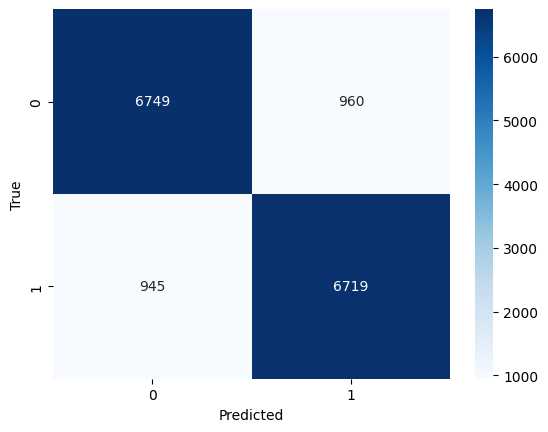

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Descargamos el modelo y realizamo

In [ ]:
import joblib
joblib.dump(best_model, 'modelo_RF_p3_final.pkl')
loaded_model = joblib.load('modelo_RF_p3_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

In [ ]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_RF_p3_final.csv', index=False)